In [4]:
import Pkg
Pkg.activate("/home/matteo/Projects/PhyloBM")

  Activating project at `~/Projects/PhyloBM`


In [5]:
using Revise

In [40]:
using PyPlot, FileIO, PottsEvolver, FastaIO, BioSeqInt, TreeCorr, TreeTools, StatsBase, LinearAlgebra

In [7]:
using SequenceLogos: logo_from_matrix, plot_sequence_logo_aa

In [8]:
import PyPlot.subplots
subplots(x,y,d) = subplots(x,y, figsize=(y*d, x*d))

subplots (generic function with 2 methods)

# Potts model

In [10]:
file_params_no_reweight = "/home/matteo/Projects/PhyloBM/DBD/notebooks/params_no_reweight.dat"
lines = readlines(file_params_no_reweight)
L = parse(Int, split(lines[end])[2]) + 1
q = length(aa_alphabet.char_to_index)
J_no_reweight = zeros(q, q, L, L)
h_no_reweight = zeros(q, L)
for line in lines
    fields =split(line)
    if (length(fields) == 6) && (fields[1] == "J")
        _, i, j, ai, aj, val = fields
        J_no_reweight[aa_alphabet.char_to_index[ai[1]],  aa_alphabet.char_to_index[aj[1]], parse(Int, i)+1, parse(Int, j)+1] = parse(Float64, val)
        J_no_reweight[aa_alphabet.char_to_index[aj[1]], aa_alphabet.char_to_index[ai[1]], parse(Int, j)+1,  parse(Int, i)+1] = parse(Float64, val)
    elseif (length(fields) == 4) && (fields[1] == "h")
        _, i, ai, val = fields
        h_no_reweight[aa_alphabet.char_to_index[ai[1]], parse(Int, i)+1] = parse(Float64, val)
    else
        print(line * ": Unrecognized format for parameter.")
        break
    end
end

In [11]:
potts_no_reweight = PottsGraph(J_no_reweight, h_no_reweight, 1.0, aa_alphabet)
potts_no_reweight

PottsGraph{Float64}: dimensions (L=76, q=21) -- β=1.0 -- Alphabet{Char,Int64}: ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

In [12]:
file_params_reweight = "/home/matteo/Projects/PhyloBM/DBD/notebooks/params_reweight.dat"
lines = readlines(file_params_reweight)
L = parse(Int, split(lines[end])[2]) + 1
q = length(aa_alphabet.char_to_index)
J_reweight = zeros(q, q, L, L)
h_reweight = zeros(q, L)
for line in lines
    fields =split(line)
    if (length(fields) == 6) && (fields[1] == "J")
        _, i, j, ai, aj, val = fields
        J_reweight[aa_alphabet.char_to_index[ai[1]],  aa_alphabet.char_to_index[aj[1]], parse(Int, i)+1, parse(Int, j)+1] = parse(Float64, val)
        J_reweight[aa_alphabet.char_to_index[aj[1]], aa_alphabet.char_to_index[ai[1]], parse(Int, j)+1,  parse(Int, i)+1] = parse(Float64, val)
    elseif (length(fields) == 4) && (fields[1] == "h")
        _, i, ai, val = fields
        h_reweight[aa_alphabet.char_to_index[ai[1]], parse(Int, i)+1] = parse(Float64, val)
    else
        print(line * ": Unrecognized format for parameter.")
        break
    end
end

In [13]:
potts_reweight = PottsGraph(J_reweight, h_reweight, 1.0, aa_alphabet)
potts_reweight

PottsGraph{Float64}: dimensions (L=76, q=21) -- β=1.0 -- Alphabet{Char,Int64}: ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# MSA

In [14]:
fasta_dbd = "/home/matteo/Data/DBD/DBD_alignment.uniref90.cov80_clean.a2m";

In [15]:
wt_int = [2,10,18,2,6,3,15,1,16,6,20,7,20,6,18,10,16,2,4,6,2,9,1,5,5,9,15,16,8,14,6,16,18,4,20,17,2,13,1,
17,12,4,2,9,8,3,9,7,15,15,9,16,2,14,1,2,15,10,14,9,2,5,4,18,6,11,11,9,4,6,18,15,9,3,15,12]
wt_int = map(x -> x == q ? 1 : x+1, wt_int)
wt_seq = map(x-> aa_alphabet.index_to_char[x], wt_int)|> String

@assert length(wt_seq) == L

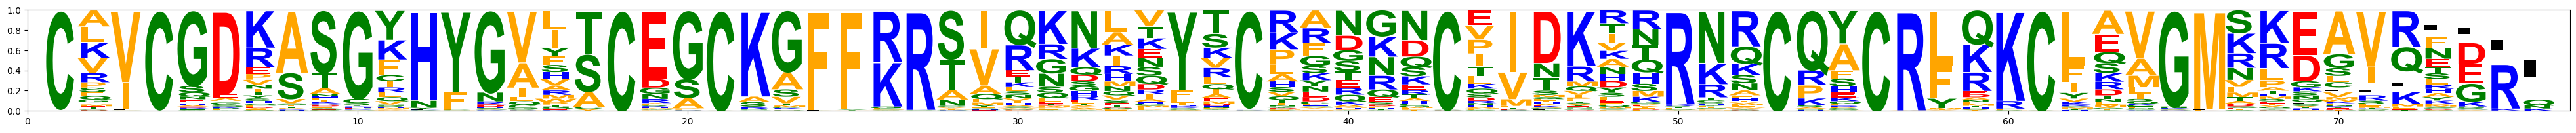

In [16]:
figure(figsize=(50,2))
logo_from_matrix(compute_frequencies(fasta_dbd, q=q, L=L, char_to_int=aa_alphabet.char_to_index),
    String(map(x->aa_alphabet.index_to_char[x], collect(1:q)))) |> plot_sequence_logo_aa
gcf()

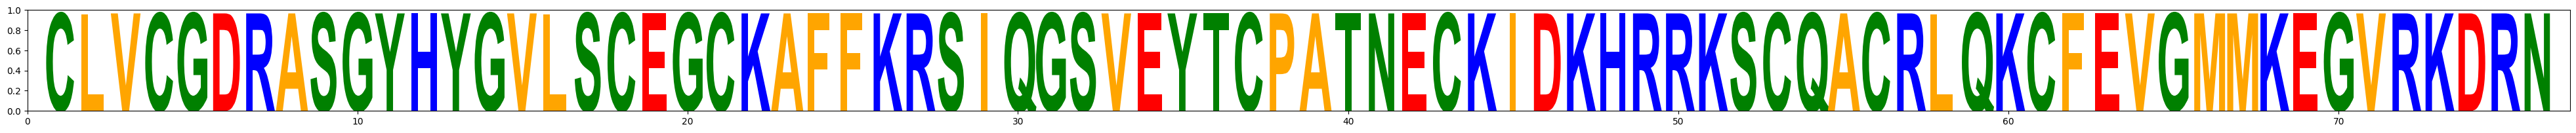

In [17]:
figure(figsize=(50,2))
logo_from_matrix(compute_frequencies([wt_seq], q=q, L=L, char_to_int=aa_alphabet.char_to_index),
    String(map(x->aa_alphabet.index_to_char[x], collect(1:q)))) |> plot_sequence_logo_aa
gcf()

In [18]:
msa_fasta = readfasta(fasta_dbd)
msa_z = zeros(Int, L, length(msa_fasta))
for (id, entry) in pairs(msa_fasta)
    seq = collect(entry[2])
    for (i, aa) in pairs(seq)
        msa_z[i, id] = aa_alphabet.char_to_index[aa]
    end
end
msa_z
        

76×24944 Matrix{Int64}:
  3   3   3   3   3   3   3   3   3  …   3   1   3   3   3   3   3   3   3
 19  19   5   5   5  16   2   2  19     10   1  11   2   2  14  16  11  11
  7   7   9   9   9  19  19  19  19     19   1  19  19  19  19  19  19  19
  3   3   3   3   3   3   3   3   3      3   1   3   3   3   3   3   3   3
  7   7   5   5   5   7   7   7   5      7   1   7   7   7   7   7   7   7
 17  17  17  17  17   4   4   4   4  …   4   1   4   4   4   4   4   4   4
  5   5  18  18  18   7  21  14  14     10   1  19  13  13  10  10  10  16
 17  17   2   2   2  13  14  17  16     17   1   2   2   2  19   2   2   2
 17  17  16  16  16   2   2  18   7     17  17  17   2   2  17  17  11  17
 16  16  17  17  17  10  10   7  17      7   7   7   3   3   7   7   7   7
  ⋮                   ⋮              ⋱   ⋮                   ⋮          
 14  14  16  16  16  14  14  19  14     16  16  10  10  10  11  16  10  14
 10  10   5   5   5  10   4  21   7      4   5   5   5   5   5   4   5   5
  8

In [19]:
msa_energies_no_reweight = map(x->energy(x, potts_no_reweight), eachcol(msa_z))
wt_energy_no_reweight = energy(wt_int, potts_no_reweight)

73.65591634735964

In [20]:
msa_energies_reweight = map(x->energy(x, potts_reweight), eachcol(msa_z))
wt_energy_reweight = energy(wt_int, potts_reweight)

95.21512772124598

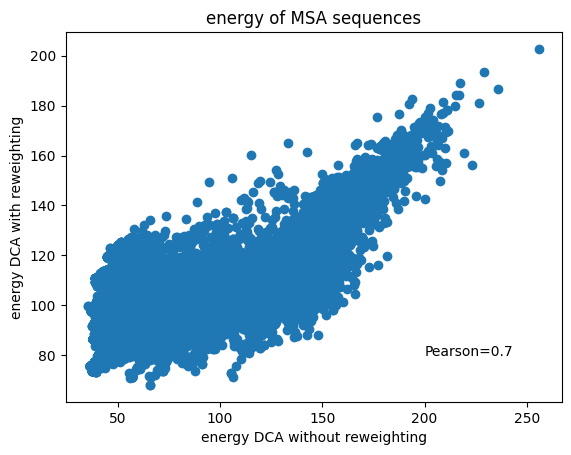

In [21]:
figure()
scatter(msa_energies_no_reweight, msa_energies_reweight)
xlabel("energy DCA without reweighting")
ylabel("energy DCA with reweighting")
title("energy of MSA sequences")
p_coeff = cor(msa_energies_no_reweight, msa_energies_reweight)
text(200, 80, "Pearson=" * string(round(p_coeff, digits=2)))
gcf()

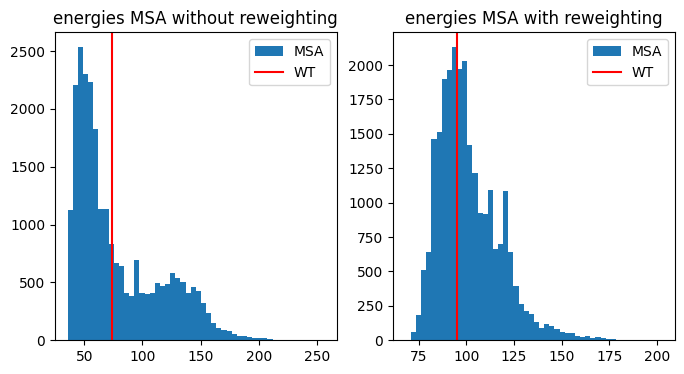

In [22]:
fig, ax = subplots(1, 2,4)

ax[1].hist(msa_energies_no_reweight, bins=50, label="MSA")
ax[1].axvline(wt_energy_no_reweight, color="red", label="WT")
ax[1].set_title("energies MSA without reweighting")
ax[1].legend()

ax[2].hist(msa_energies_reweight, bins=50, label="MSA")
ax[2].axvline(wt_energy_reweight, color="red", label="WT")
ax[2].set_title("energies MSA with reweighting")
ax[2].legend()

gcf()

# MCMC at equilibrium

In [23]:
n_trajectories_eq = 5
n_points_eq = 1000
parameters_eq = SamplingParameters(Teq=L, burnin=0, step_meaning=:proposed)

results_eq_wt_no_reweight = [mcmc_sample(potts_no_reweight, n_points_eq, parameters_eq, init=wt_int) for i in 1:n_trajectories_eq]
results_eq_random_no_reweight = [mcmc_sample(potts_no_reweight, n_points_eq, parameters_eq, init=:random_aa) for i in 1:n_trajectories_eq]

results_eq_wt_reweight = [mcmc_sample(potts_reweight, n_points_eq, parameters_eq, init=wt_int) for i in 1:n_trajectories_eq]
results_eq_random_reweight = [mcmc_sample(potts_reweight, n_points_eq, parameters_eq, init=:random_aa) for i in 1:n_trajectories_eq]

5-element Vector{@NamedTuple{sequences::Alignment{Char, Int64}, tvals::Vector{Int64}, info::Vector{Any}, params::Dict{Any, Any}}}:
 (sequences = Alignment of M=1000 sequences of length L=76, tvals = [0, 76, 152, 228, 304, 380, 456, 532, 608, 684  …  75240, 75316, 75392, 75468, 75544, 75620, 75696, 75772, 75848, 75924], info = [(proposed = 76, performed = 76, ratio = 1.0), (proposed = 76, performed = 76, ratio = 1.0), (proposed = 76, performed = 76, ratio = 1.0), (proposed = 76, performed = 76, ratio = 1.0), (proposed = 76, performed = 76, ratio = 1.0), (proposed = 76, performed = 76, ratio = 1.0), (proposed = 76, performed = 76, ratio = 1.0), (proposed = 76, performed = 76, ratio = 1.0), (proposed = 76, performed = 76, ratio = 1.0), (proposed = 76, performed = 76, ratio = 1.0)  …  (proposed = 76, performed = 76, ratio = 1.0), (proposed = 76, performed = 76, ratio = 1.0), (proposed = 76, performed = 76, ratio = 1.0), (proposed = 76, performed = 76, ratio = 1.0), (proposed = 76, performe

In [24]:
energies_eq_wt_no_reweight = [map(x -> energy(x, potts_no_reweight), res.sequences) for res in results_eq_wt_no_reweight]
energies_eq_random_no_reweight = [map(x -> energy(x, potts_no_reweight), res.sequences) for res in results_eq_random_no_reweight]

energies_eq_wt_reweight = [map(x -> energy(x, potts_reweight), res.sequences) for res in results_eq_wt_reweight]
energies_eq_random_reweight = [map(x -> energy(x, potts_reweight), res.sequences) for res in results_eq_random_reweight];

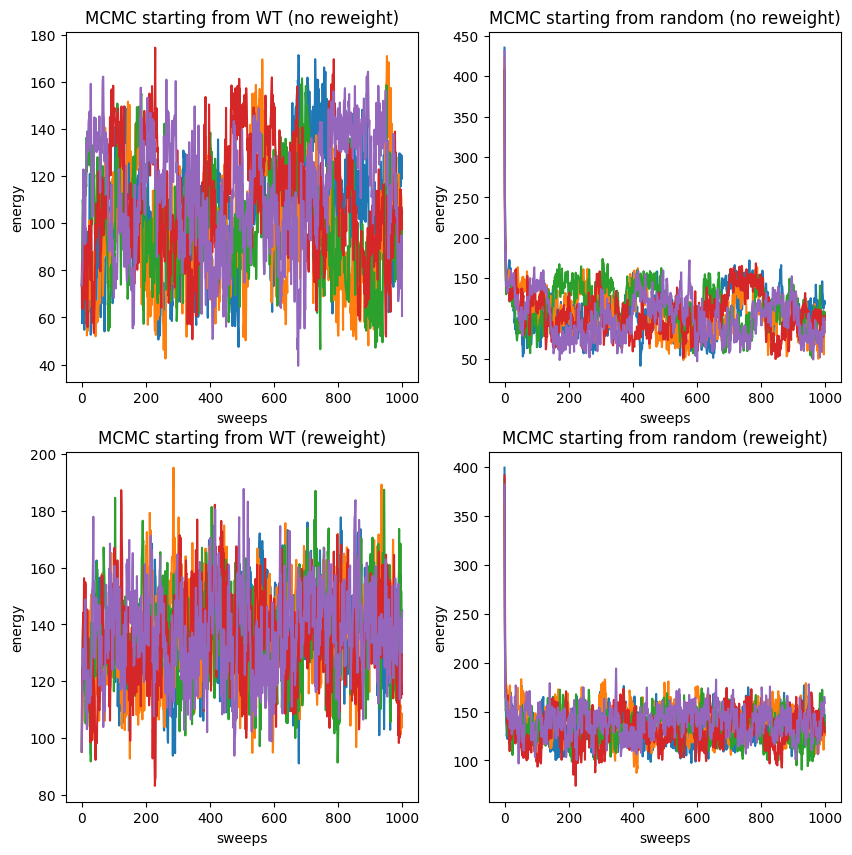

In [25]:
fig, ax = subplots(2, 2, 5)

ax[1,1].plot.(energies_eq_wt_no_reweight)
ax[1,1].set_xlabel("sweeps")
ax[1,1].set_ylabel("energy")
ax[1,1].set_title("MCMC starting from WT (no reweight)")

ax[1,2].plot.(energies_eq_random_no_reweight)
ax[1,2].set_xlabel("sweeps")
ax[1,2].set_ylabel("energy")
ax[1,2].set_title("MCMC starting from random (no reweight)")

ax[2,1].plot.(energies_eq_wt_reweight)
ax[2,1].set_xlabel("sweeps")
ax[2,1].set_ylabel("energy")
ax[2,1].set_title("MCMC starting from WT (reweight)")

ax[2,2].plot.(energies_eq_random_reweight)
ax[2,2].set_xlabel("sweeps")
ax[2,2].set_ylabel("energy")
ax[2,2].set_title("MCMC starting from random (reweight)")

gcf()

# MCMC transient

In [37]:
n_samples_mcmc = 1000
parameters_mcmc = SamplingParameters(Teq=1, burnin=L-1, step_meaning=:proposed)

results_mcmc_no_reweight = [mcmc_sample(potts_no_reweight, 1, parameters_mcmc, init=wt_int) for _ in 1:n_samples_mcmc]
msa_mcmc_no_reweight = hcat(map(x->x.sequences.data , results_mcmc_no_reweight)...)

results_mcmc_reweight = [mcmc_sample(potts_reweight, 1, parameters_mcmc, init=wt_int) for _ in 1:n_samples_mcmc]
msa_mcmc_reweight = hcat(map(x->x.sequences.data , results_mcmc_reweight)...);

# Simulation on a tree

In [27]:
n_samples_tree = 1000
blm = PottsEvolver.BranchLengthMeaning(:sweep, :round)
parameters_tree = SamplingParameters(Teq=0, burnin=0, step_meaning=:proposed, branchlength_meaning=blm)
bd_tree, completed = TreeTools.Generate.birth_death(n_samples_tree, 5.0, 0.1)

results_tree = mcmc_sample(potts_reweight, bd_tree, parameters_tree, init=wt_int)
msa_tree = results_tree.leaf_sequences.data;

In [68]:
dist_root = [distance(bd_tree.root, bd_tree["$x"]) for (x, _) in bd_tree.lleaves];

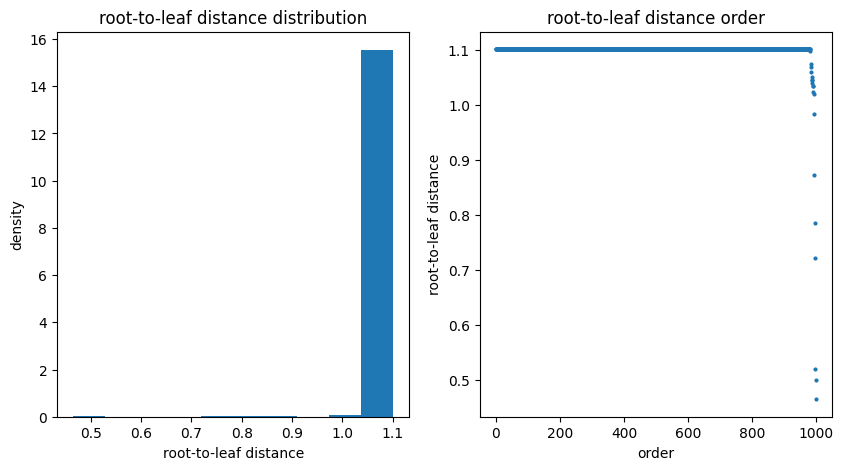

In [80]:
fig, ax = subplots(1,2,5)

ax[1].hist(dist_root, density=true)
ax[1].set_xlabel("root-to-leaf distance")
ax[1].set_ylabel("density")
ax[1].set_title("root-to-leaf distance distribution")

ax[2].plot(sort(dist_root, rev=true), marker="o", linestyle="none", markersize=2)
ax[2].set_ylabel("root-to-leaf distance")
ax[2].set_xlabel("order")
ax[2].set_title("root-to-leaf distance order")
gcf()

# Analysis

### Pairwise distance

In [28]:
dist_pairwise_mcmc_no_reweight = zeros(Int, n_samples_mcmc*(n_samples_mcmc-1)÷2)
cnt =1
for i in 1:n_samples_mcmc
    for j in 1:i-1
        dist_pairwise_mcmc_no_reweight[cnt] = sum(msa_mcmc_no_reweight[:,i] .!= msa_mcmc_no_reweight[:,j])
        cnt += 1
    end
end

In [29]:
dist_pairwise_mcmc_reweight = zeros(Int, n_samples_mcmc*(n_samples_mcmc-1)÷2)
cnt =1
for i in 1:n_samples_mcmc
    for j in 1:i-1
        dist_pairwise_mcmc_reweight[cnt] = sum(msa_mcmc_reweight[:,i] .!= msa_mcmc_reweight[:,j])
        cnt += 1
    end
end

In [30]:
dist_pairwise_tree = zeros(Int, n_samples_tree*(n_samples_tree-1)÷2)
cnt =1
for i in 1:n_samples_tree
    for j in 1:i-1
        dist_pairwise_tree[cnt] = sum(msa_tree[:,i] .!= msa_tree[:,j])
        cnt += 1
    end
end

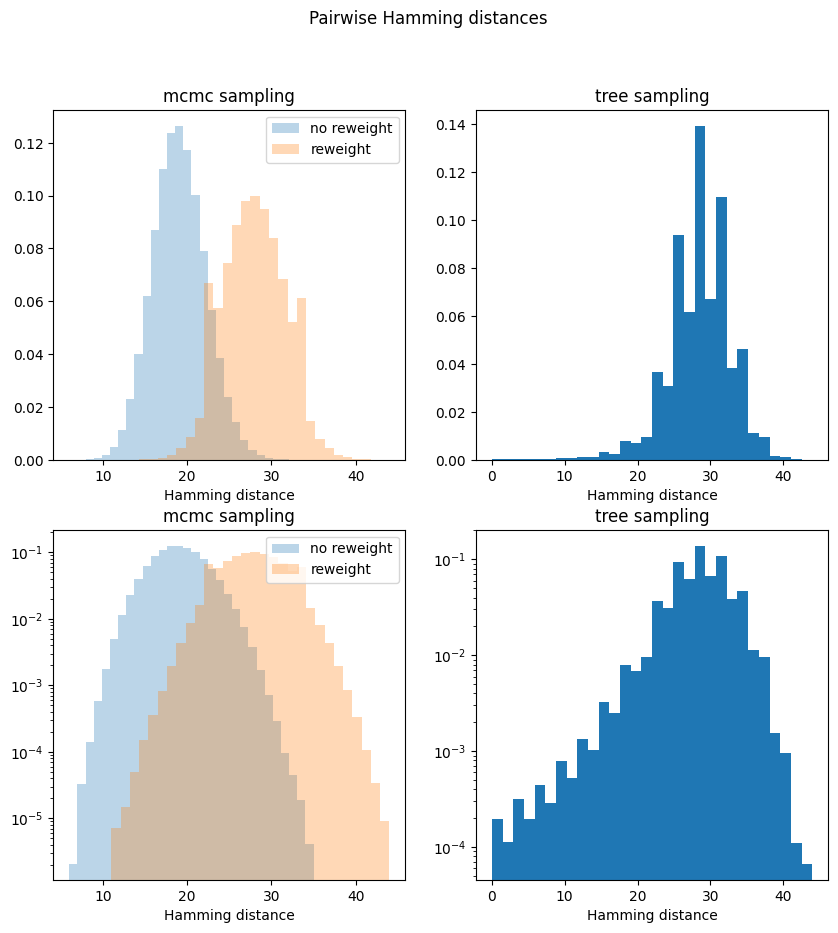

In [31]:
fig, ax = subplots(2,2,5)
fig.suptitle("Pairwise Hamming distances")

ax[1,1].hist(dist_pairwise_mcmc_no_reweight, bins=30, label="no reweight", alpha=0.3, density=true)
ax[1,1].hist(dist_pairwise_mcmc_reweight, bins=30, label="reweight", alpha=0.3, density=true)
ax[1,1].set_title("mcmc sampling")
ax[1,1].set_xlabel("Hamming distance")
ax[1,1].legend()

ax[1,2].hist(dist_pairwise_tree, bins=30, density=true)
ax[1,2].set_xlabel("Hamming distance")
ax[1,2].set_title("tree sampling")

ax[2,1].hist(dist_pairwise_mcmc_no_reweight, bins=30, label="no reweight", alpha=0.3, density=true)
ax[2,1].hist(dist_pairwise_mcmc_reweight, bins=30, label="reweight", alpha=0.3, density=true)
ax[2,1].set_title("mcmc sampling")
ax[2,1].set_xlabel("Hamming distance")
ax[2,1].set_yscale(:log)
ax[2,1].legend()

ax[2,2].hist(dist_pairwise_tree, bins=30, density=true)
ax[2,2].set_xlabel("Hamming distance")
ax[2,2].set_title("tree sampling")
ax[2,2].set_yscale(:log)

gcf()

### Correlation matrix

In [33]:
function compute_corr_matrix(z)
    q = max(20, maximum(z))
    L, M = size(z)

    fi = zeros(q, L)
    for m in 1:M
        for i in 1:L
            fi[z[i,m], i] += 1.0
        end
    end
    fi ./= M
    fi = reshape(fi, q*L, 1)

    fij = zeros(q, L, q, L)
    for m in 1:M
        for i in 1:L
            for j in 1:L
                fij[z[i,m], i, z[j,m], j] += 1.0
            end
        end
    end
    fij ./= M
    fij = reshape(fij, q*L, q*L)

    return fij .- fi*fi'
end

compute_corr_matrix (generic function with 1 method)

In [39]:
cor_mcmc_no_reweight = compute_corr_matrix(msa_mcmc_no_reweight)
cor_mcmc_reweight = compute_corr_matrix(msa_mcmc_reweight)
cor_tree = compute_corr_matrix(msa_tree);


In [41]:
spectrum_mcmc_no_reweight = eigen(cor_mcmc_no_reweight).values
spectrum_mcmc_reweight = eigen(cor_mcmc_reweight).values
spectrum_tree = eigen(cor_tree).values;

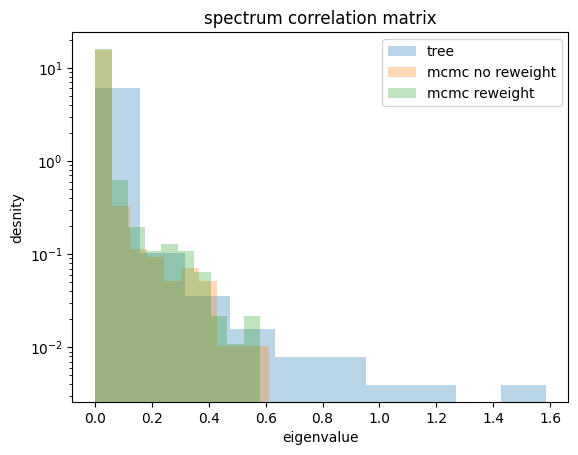

In [51]:
figure()
hist(spectrum_tree, label="tree", alpha=0.3, density=true)
hist(spectrum_mcmc_no_reweight, label="mcmc no reweight", alpha=0.3, density=true)
hist(spectrum_mcmc_reweight, label="mcmc reweight", alpha=0.3, density=true)
legend()
yscale(:log)
ylabel("desnity")
xlabel("eigenvalue")
title("spectrum correlation matrix")
gcf()